Author: Bram van Duinen

Last edit date: 23 nov 2023

Content: Calculating the anomalies of meteorological variables (wind speed, insolation, surface temperature) with respect to their monthly means for co-occurring events between two chosen countries, and also for cases where country_1 has an event, but country_2 does not.

TODO:
- The calculation of the anomalies is really slow. See how it can be sped up.
- Calculation of mean (composite) anomalies is now really ugly, but it works. The 'nicer' way did not work yet. Try to find out why.

In [111]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy
# from scipy.ndimage import minimum_filter, maximum_filter
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime, timedelta

In [112]:
date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
# Create folders for Figures from today
dir_Figures = f'../Results/Figures/{rundate}/co_occur'

if not os.path.exists(dir_Figures):
    print('Creating dir %s' % dir_Figures)
    os.makedirs(dir_Figures)

In [113]:
rundate_cooccur = 20231121
df_cooccurrences = pd.read_csv(f'../Results/df_co_occurrences_{rundate_cooccur}.csv')

In [114]:
c_1 = 'NLD'
c_2 = 'DEU'

co = df_cooccurrences[(df_cooccurrences['country_1'] == c_1) & (df_cooccurrences['country_2'] == c_2)]
date_co = co['date_1'].values
run_co = co['run'].values

co_self = df_cooccurrences[(df_cooccurrences['country_1'] == c_1) & (df_cooccurrences['country_2'] == c_1)]

In [115]:
co = co.copy()
co_self = co_self.copy()

num_co = len(co)

co['key'] = co['date_1'].astype(str) + '-' + co['run'].astype(str)
co_self['key'] = co_self['date_1'].astype(str) + '-' + co_self['run'].astype(str)

noco = co_self[~co_self['key'].isin(co['key'])]
num_noco = len(noco)

date_noco = noco['date_1'].values
run_noco = noco['run'].values

Wind

In [116]:
daily = '/net/pc200256/nobackup/users/most/LENTIS/present/day/'

wind = xr.open_mfdataset(daily + 'sfcWind_d/sfcWind_d_ECEarth3_h*.nc', combine='nested', concat_dim='run', chunks={})
windvar = 'sfcWind'

wind['run'] = wind['run'] + 10

In [117]:
lons = wind['lon'].values #only has to done for one variable, all same grid
lats = wind['lat'].values

In [118]:
monthly_wind = xr.open_dataarray('../Data/monthly_wind.nc')

In [119]:
dwind_co_all = wind[windvar].sel(time=date_co).sel(run=run_co).groupby('time.month') - monthly_wind
# dwind_co = dwind_co_all.sum(dim='time').sum(dim='run').compute()/(num_co*2) #this is really hacky, problem is that time and run are essentially the same dimension, but have to do mean over both.

dwind_co = dwind_co_all[0][0]

for i in range(1, num_co):
    dwind_co += dwind_co_all[i][i]
    
dwind_co = dwind_co.values/num_co

dwind_noco_all = wind[windvar].sel(time=date_noco).sel(run=run_noco).groupby('time.month') - monthly_wind
# dwind_noco = dwind_noco_all.sum(dim='time').sum(dim='run').compute()/(num_noco*2)
dwind_noco = dwind_noco_all[0][0]

for i in range(1, num_noco):
    dwind_noco += dwind_noco_all[i][i]
    
dwind_noco = dwind_noco.values/num_co

dwind = (dwind_co - dwind_noco) #difference between co-occurrence and non-co-occurrence

Insolation

In [120]:
sun = xr.open_mfdataset(daily + 'rsds_d/rsds_d_ECEarth3_h*.nc', combine='nested', concat_dim='run', chunks={})
sunvar = 'rsds'

sun['run'] = sun['run'] + 10

In [121]:
monthly_sun = xr.open_dataarray('../Data/monthly_sun.nc')

In [122]:
dsun_co_all = sun[sunvar].sel(time=date_co).sel(run=run_co).groupby('time.month') - monthly_sun
# dsun_co = dsun_co_all.sum(dim='time').sum(dim='run').compute()/(num_co*2)

dsun_co = dsun_co_all[0][0]

for i in range(1, num_co):
    dsun_co += dsun_co_all[i][i]
    
dsun_co = dsun_co.values/num_co

dsun_noco_all = sun[sunvar].sel(time=date_noco).sel(run=run_noco).groupby('time.month') - monthly_sun
# dsun_noco = dsun_noco_all.sum(dim='time').sum(dim='run').compute()/(num_noco*2)
dsun_noco = dsun_noco_all[0][0]

for i in range(1, num_noco):
    dsun_noco += dsun_noco_all[i][i]
    
dsun_noco = dsun_noco.values/num_noco

dsun = (dsun_co - dsun_noco) #difference between co-occurrence and non-co-occurrence

Temperature

In [123]:
temp = xr.open_mfdataset(daily + 'tas_d/tas_d_ECEarth3_h*.nc', combine='nested', concat_dim='run', chunks={})
tempvar = 'tas'

temp['run'] = temp['run'] + 10

In [124]:
monthly_temp = xr.open_dataarray('../Data/monthly_temp.nc')

In [125]:
dtemp_co_all = temp[tempvar].sel(time=date_co).sel(run=run_co).groupby('time.month') - monthly_temp
# dtemp_co = dtemp_co_all.sum(dim='time').sum(dim='run').compute()/(num_co*2) #this is really hacky, problem is that time and run are essentially the same dimension, but have to do mean over both.
dtemp_co = dtemp_co_all[0][0]

for i in range(1, num_co):
    dtemp_co += dtemp_co_all[i][i]
    
dtemp_co = dtemp_co.values/num_co

dtemp_noco_all = temp[tempvar].sel(time=date_noco).sel(run=run_noco).groupby('time.month') - monthly_temp
# dtemp_noco = dtemp_noco_all.sum(dim='time').sum(dim='run').compute()/(num_noco*2)

dtemp_noco = dtemp_noco_all[0][0]

for i in range(1, num_noco):
    dtemp_noco += dtemp_noco_all[i][i]
    
dtemp_noco = dtemp_noco.values/num_noco

dtemp = (dtemp_co - dtemp_noco) #difference between co-occurrence and non-co-occurrence

Plots

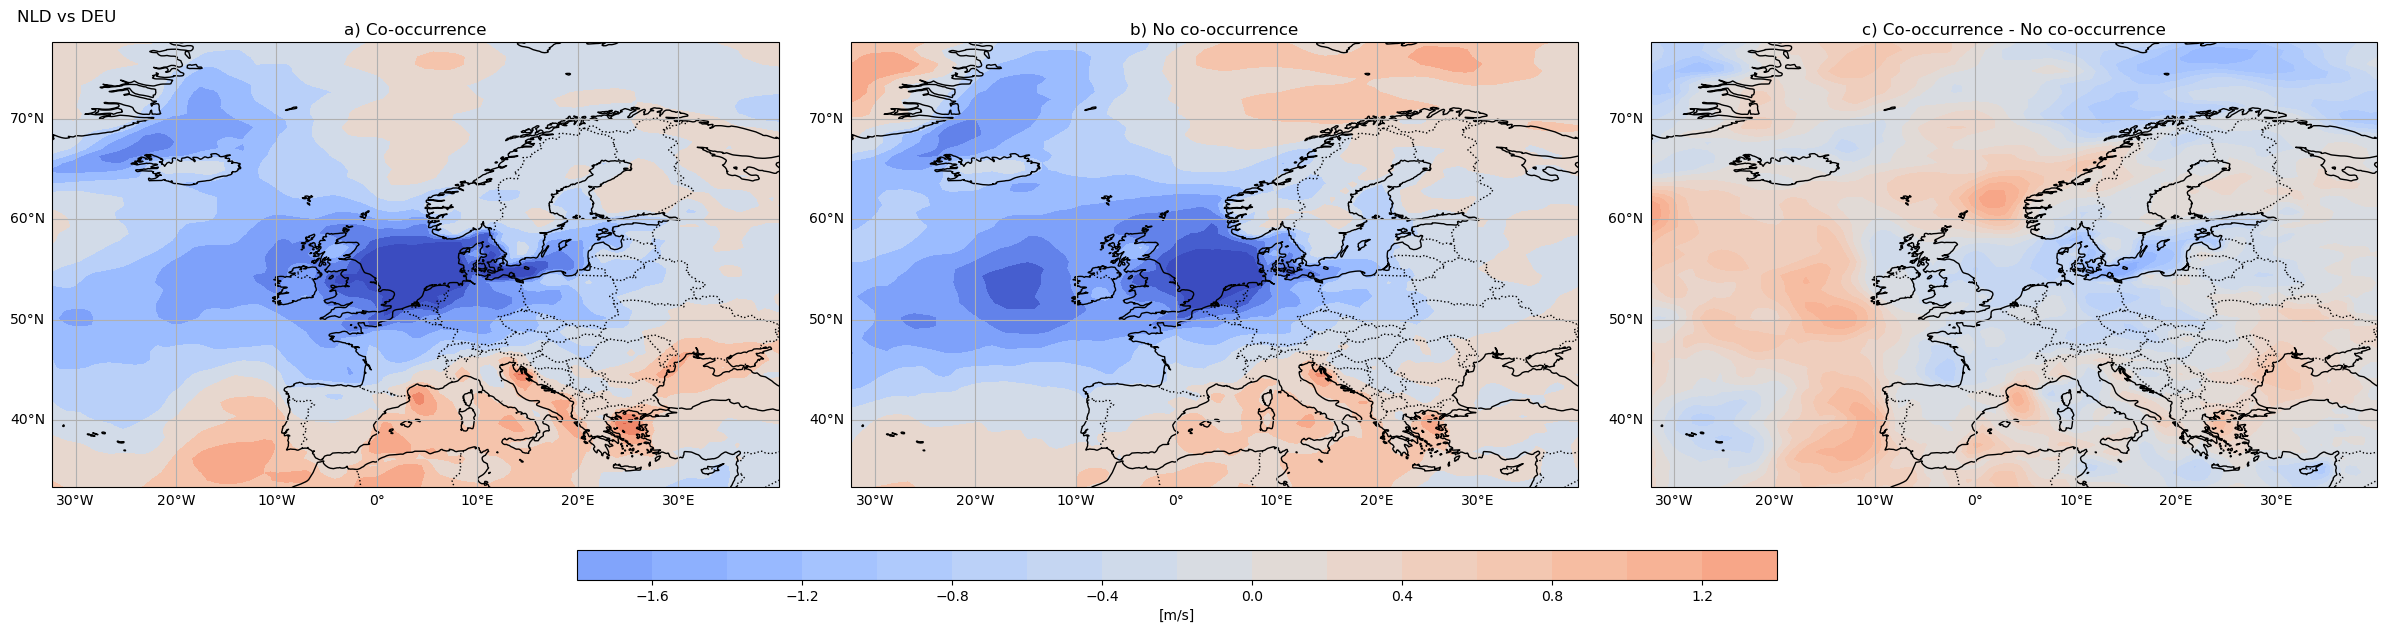

In [140]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

data_vars = [dwind_co, dwind_noco, dwind]
titles = ['a) Co-occurrence', 'b) No co-occurrence', 'c) Co-occurrence - No co-occurrence']

for ax, data_var, title in zip(axs, data_vars, titles):
    ax.set_extent([lons[0], 40, lats[0], 75])
    im1 = ax.contourf(lons, lats, data_var, levels=16, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0), vmin=-3, vmax=3)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(title)

fig.suptitle(f'{c_1} vs {c_2}', x = 0.13, y = 0.75)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.3, 0.18, 0.4, 0.03])

fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', shrink=0.5, label='[m/s]', pad = 0.02)

plt.savefig(f'{dir_Figures}/{c_1}_{c_2}_wind.png', dpi=300, bbox_inches='tight')

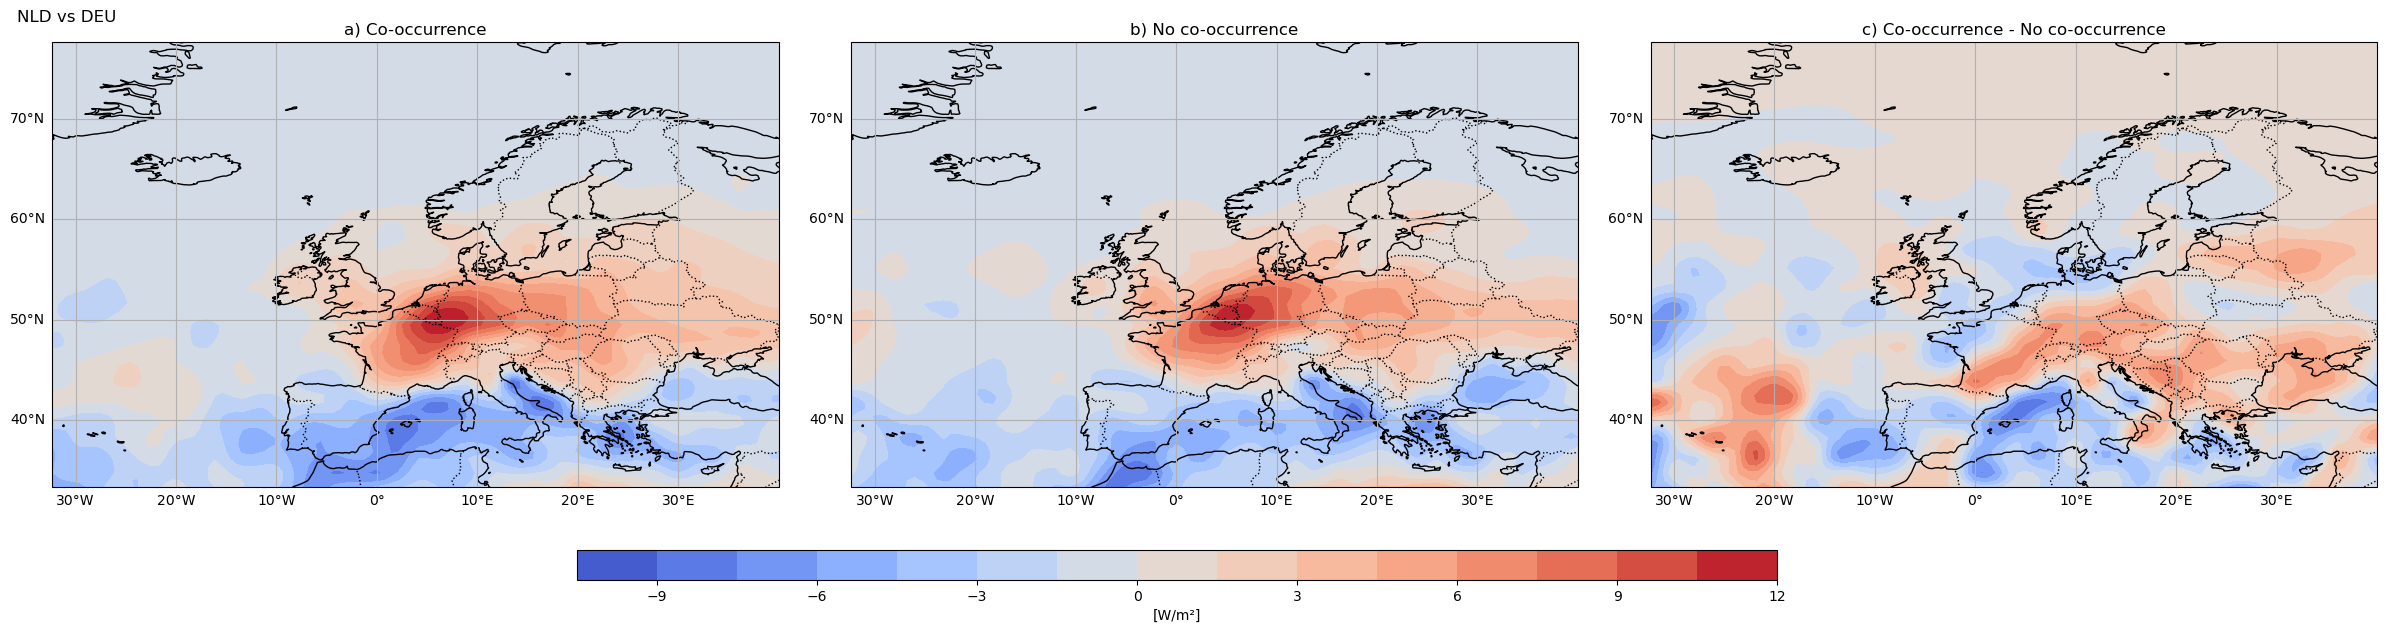

In [138]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

data_vars = [dsun_co, dsun_noco, dsun]
titles = ['a) Co-occurrence', 'b) No co-occurrence', 'c) Co-occurrence - No co-occurrence']

for ax, data_var, title in zip(axs, data_vars, titles):
    ax.set_extent([lons[0], 40, lats[0], 75])
    im1 = ax.contourf(lons, lats, data_var, levels = 16, norm=TwoSlopeNorm(vcenter=0), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(title)

fig.suptitle(f'{c_1} vs {c_2}', x = 0.13, y = 0.75)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.3, 0.18, 0.4, 0.03])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', shrink=0.5, label='[W/m\u00b2]', pad = 0.02)

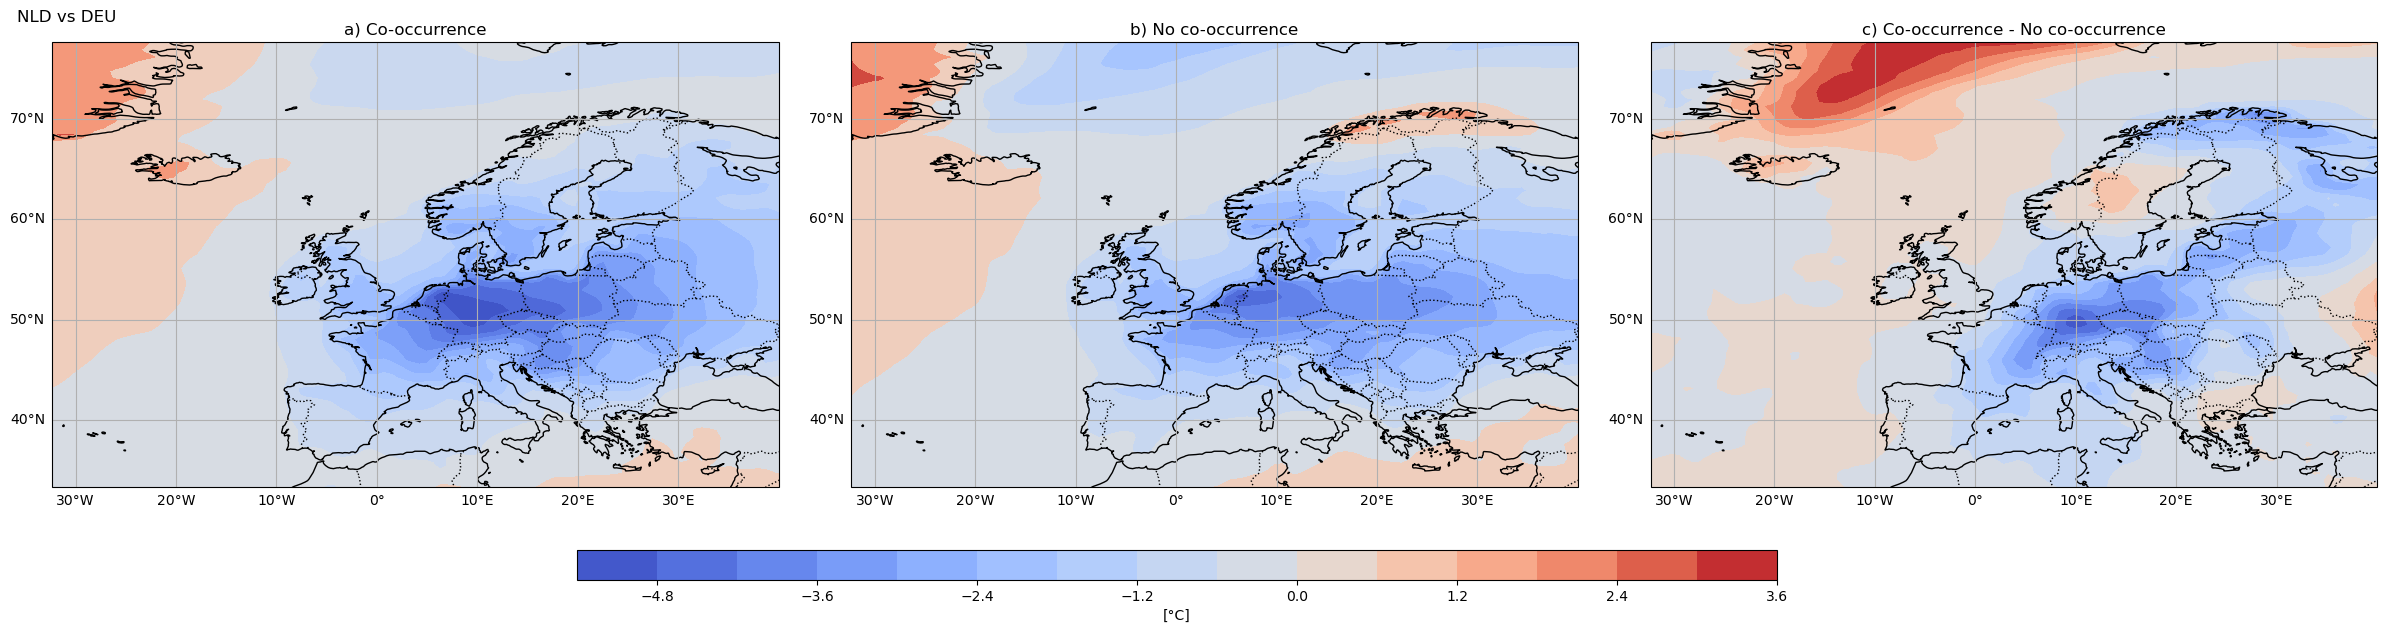

In [141]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})

data_vars = [dtemp_co, dtemp_noco, dtemp]
titles = ['a) Co-occurrence', 'b) No co-occurrence', 'c) Co-occurrence - No co-occurrence']

for ax, data_var, title in zip(axs, data_vars, titles):
    ax.set_extent([lons[0], 40, lats[0], 75])
    im1 = ax.contourf(lons, lats, data_var, levels=16, norm=TwoSlopeNorm(vcenter=0), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(title)

fig.suptitle(f'{c_1} vs {c_2}', x = 0.13, y = 0.75)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.3, 0.18, 0.4, 0.03])

fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', shrink=0.5, label='[\u00b0C]', pad = 0.02)

plt.savefig(f'{dir_Figures}/{c_1}_{c_2}_temp.png', dpi=300, bbox_inches='tight')